In [1]:
import sys
import os
from typing import List, Dict

current_directory = os.getcwd()
src_directory = os.path.join(current_directory, 'src')
sys.path.append(src_directory)

from src.bounding_box_processor import NMSWithBoundaryProcessor, GreedyNMMWithBoundaryProcessor
from src.utils import load_json_files, draw_boxes, roi_tlwh_2_tlbr


In [2]:
def filter_player_data_with_nmm_or_nms(
        player_data: List[Dict],
        roi_tlwh_list: List[List[float]],
        use_nmm: bool = True,
        use_nms: bool = False,
        use_bbox_ids_on_boundaries: bool = True,
        delta: int = 20,
        match_metric: str = "IOU",
        match_threshold: float = 0.5,
        match_threshold_boundary: float = 0.1,
        ) -> List[Dict]:

    """
    Filters player bounding box data using either Greedy Non-Maximum Merging (Greedy NMM) 
    or Non-Maximum Suppression (NMS) with consideration for ROI boundaries, depending on the provided flags.

    This function processes the input list of player bounding boxes and applies the selected filtering algorithm:
    - If the `use_nmm` flag is set to `True`, the Greedy NMM algorithm will be used for filtering.
    - If the `use_nms` flag is set to `True`, the NMS algorithm will be used for filtering.
    
    Only one of the flags (`use_nmm` or `use_nms`) can be set to `True` at a time.
    
    Arguments:
        player_data (List[Dict]): A list of dictionaries, where each dictionary contains information about the bounding box 
                                  and score for a player.
        use_nmm (bool): Flag indicating whether to use the Greedy NMM algorithm for filtering. Default is `True`.
        roi_tlwh_list (list): A dictionary containing the Region of Interest (ROI) data in TLWH (Top-Left, Width, Height) format.
        use_nms (bool): Flag indicating whether to use the NMS algorithm for filtering. Default is `False`.
        use_bbox_ids_on_boundaries (bool): Flag for using bounding boxes that intersect with the ROI boundaries. 
        delta (int): Parameter for adjusting the expansion of the ROI boundaries.
        match_metric (str): Metric for comparing bounding boxes (e.g., "IOU").
        match_threshold (float): Threshold for the match metric for objects far from the boundaries.
        match_threshold_boundary (float): Threshold for the match metric for objects near the boundaries.
        
    Returns:
        List[Dict]: A list of filtered player data based on the selected algorithm.
    """
    # Ensure that only one of the flags is True
    if use_nmm and use_nms:
        raise ValueError("You can only use one of the flags: 'use_nmm' or 'use_nms' (but not both at the same time).")
    if not (use_nmm or use_nms):
        raise ValueError("At least one flag must be set: 'use_nmm' or 'use_nms'.")


    filtered_player_data = []


    if use_nmm:
        nmm_class = GreedyNMMWithBoundaryProcessor(
            player_bboxes_list=player_data,
            roi_tlwh_list=roi_tlwh_list,
            delta=delta,
            match_metric=match_metric,
            match_threshold=match_threshold,
            match_threshold_boundary=match_threshold_boundary
        )
        filtered_player_data = nmm_class.filter_bboxes(use_bbox_ids_on_boundaries=use_bbox_ids_on_boundaries)

    elif use_nms:
        nms_class = NMSWithBoundaryProcessor(
            player_bboxes_list=player_data,
            roi_tlwh_list=roi_tlwh_list,
            delta=delta,
            match_metric=match_metric,
            match_threshold=match_threshold,
            match_threshold_boundary=match_threshold_boundary
        )
        filtered_player_data = nms_class.filter_bboxes(use_bbox_ids_on_boundaries=use_bbox_ids_on_boundaries)

    return filtered_player_data


In [3]:
file_path_player_bboxes = 'data/7b96f3df-d8f8-4cdc-a106-6adadbf6593b_sample.json'
file_path_roi_tlwh = 'data/roi_tlwh.json'

player_bboxes_list = load_json_files(file_path_player_bboxes)
roi_tlwh_list = load_json_files(file_path_roi_tlwh)
roi_tlbr_list = roi_tlwh_2_tlbr(roi_tlwh_list)

## Why should NMM be used instead of NMS?
Below are three images for frame_id = 7150:

The first — the initial boxes without filtering.  
The second — the result of applying NMS.  
The third — the result of applying NMM.  

Pay attention to the following:  
As you can see, the correct rendering is observed only in the third image with the use of NMM.

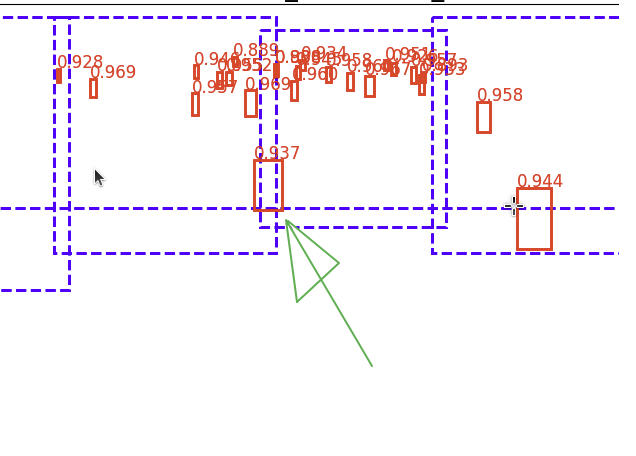



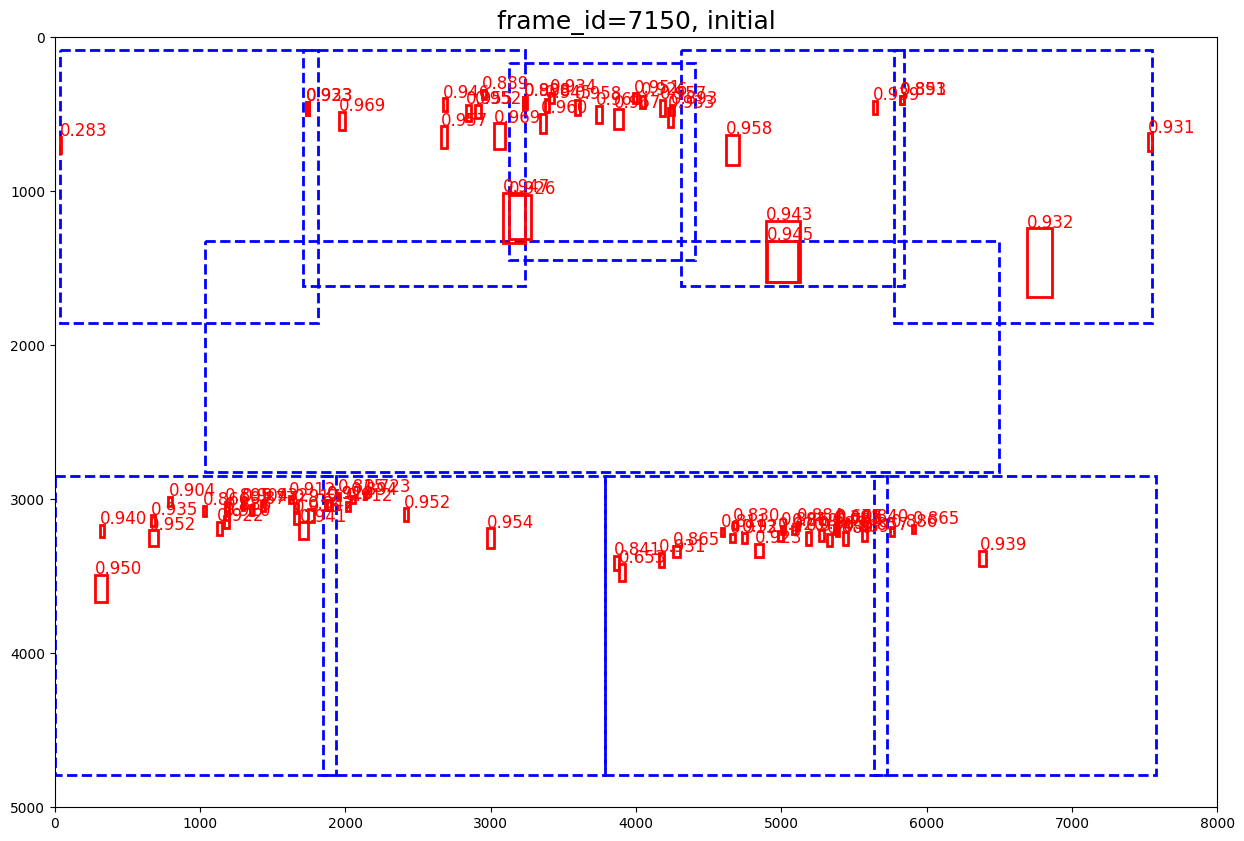

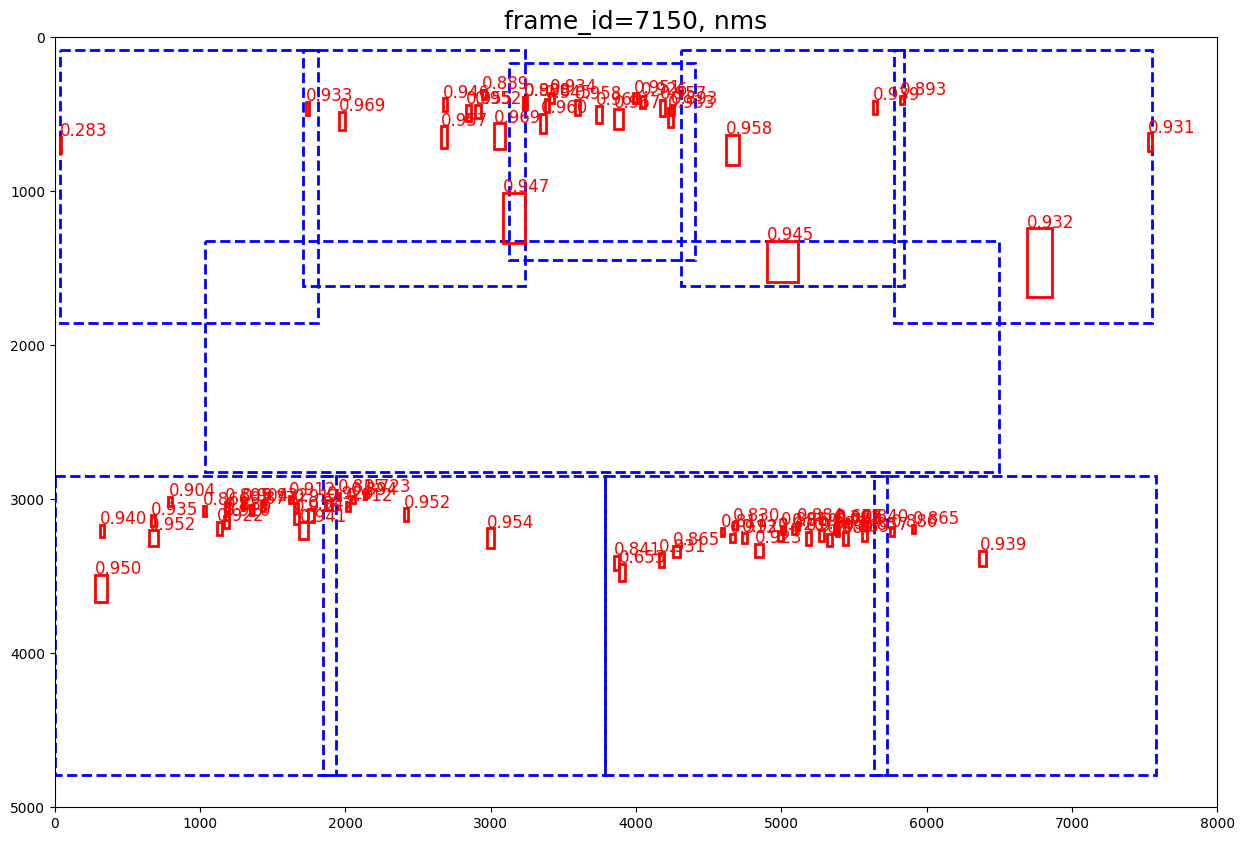

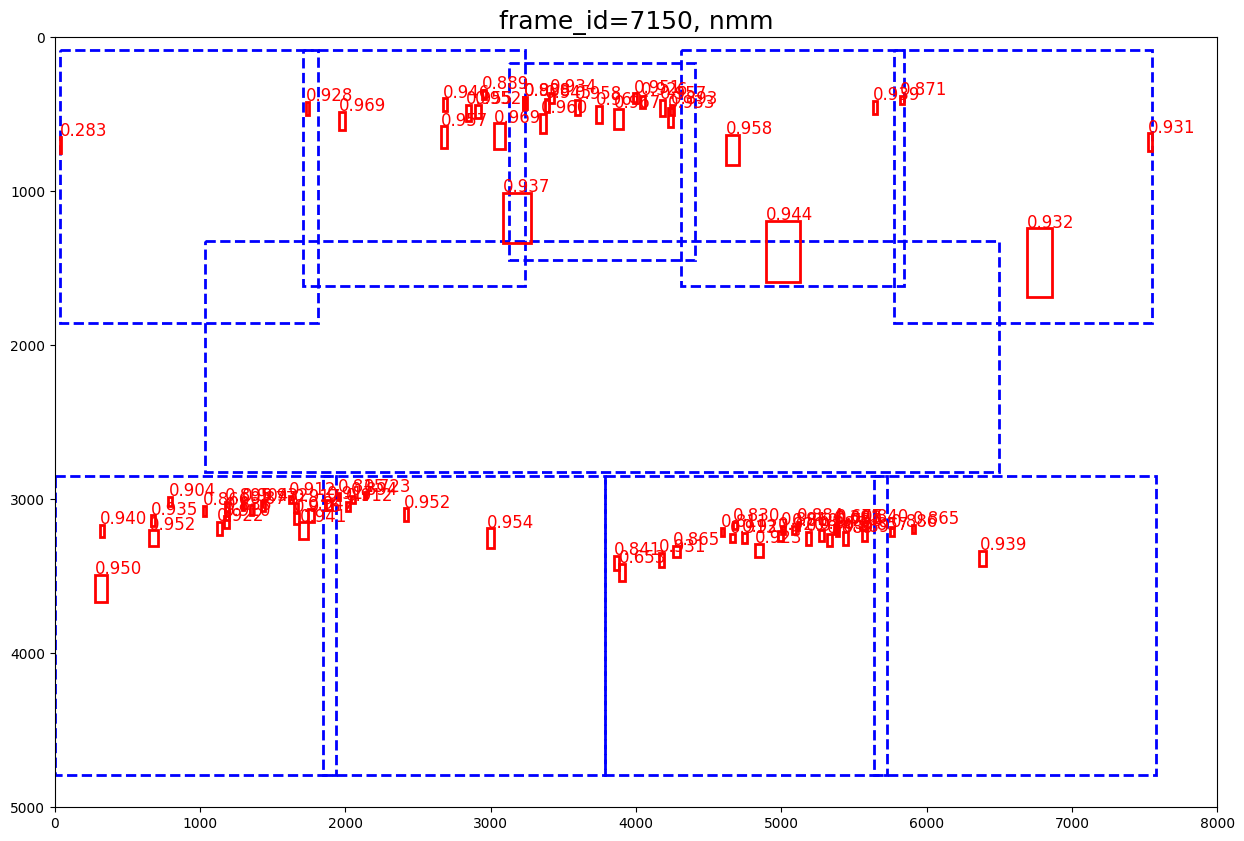

In [4]:
filtered_player_nmm = filter_player_data_with_nmm_or_nms(player_bboxes_list, roi_tlwh_list)
filtered_player_nms = filter_player_data_with_nmm_or_nms(player_bboxes_list, roi_tlwh_list,use_nmm=False, use_nms=True)

frame_id = 7150
draw_boxes(player_bboxes_list, frame_id, roi_tlbr = roi_tlbr_list, title = f"frame_id={frame_id}, initial")
draw_boxes(filtered_player_nms, frame_id, roi_tlbr = roi_tlbr_list, title = f"frame_id={frame_id}, nms")
draw_boxes(filtered_player_nmm, frame_id, roi_tlbr = roi_tlbr_list, title = f"frame_id={frame_id}, nmm")

## Why should use_bbox_ids_on_boundaries be used?
The use_bbox_ids_on_boundaries parameter allows setting two different thresholds for bounding boxes depending on whether they are near the boundaries of the Region of Interest (ROI) or far from them.

If only one threshold is used (without considering the boundaries), it can be difficult to find the optimal value, as objects near the boundary require stricter criteria than those further away.

Below are three images for frame_id = 7973:  
The first — the initial boxes without filtering.  
The second — the result of applying NMM without using use_bbox_ids_on_boundaries, with match_threshold = 0.5.  
The third — the result of applying NMM with match_threshold = 0.1.  
The fourth — the result of applying NMM with the use of use_bbox_ids_on_boundaries.  
Pay attention to the following:

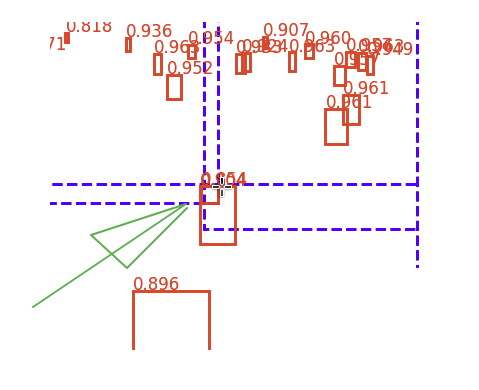

In the second image, no merging occurred due to the high match_threshold.  
The threshold had to be lowered to 0.1 (third image) to make the artifact disappear, but such a significant decrease in the threshold leads to merging of true bounding boxes in other areas far from the ROI boundaries.

In [5]:
filtered_player_nmm_without_0 = filter_player_data_with_nmm_or_nms(
    player_bboxes_list, roi_tlwh_list,use_bbox_ids_on_boundaries = False, match_threshold = 0.5,)

filtered_player_nmm_without_1 = filter_player_data_with_nmm_or_nms(
    player_bboxes_list, roi_tlwh_list,use_bbox_ids_on_boundaries = False, match_threshold = 0.1,)

filtered_player_nmm_good= filter_player_data_with_nmm_or_nms(
    player_bboxes_list, roi_tlwh_list)

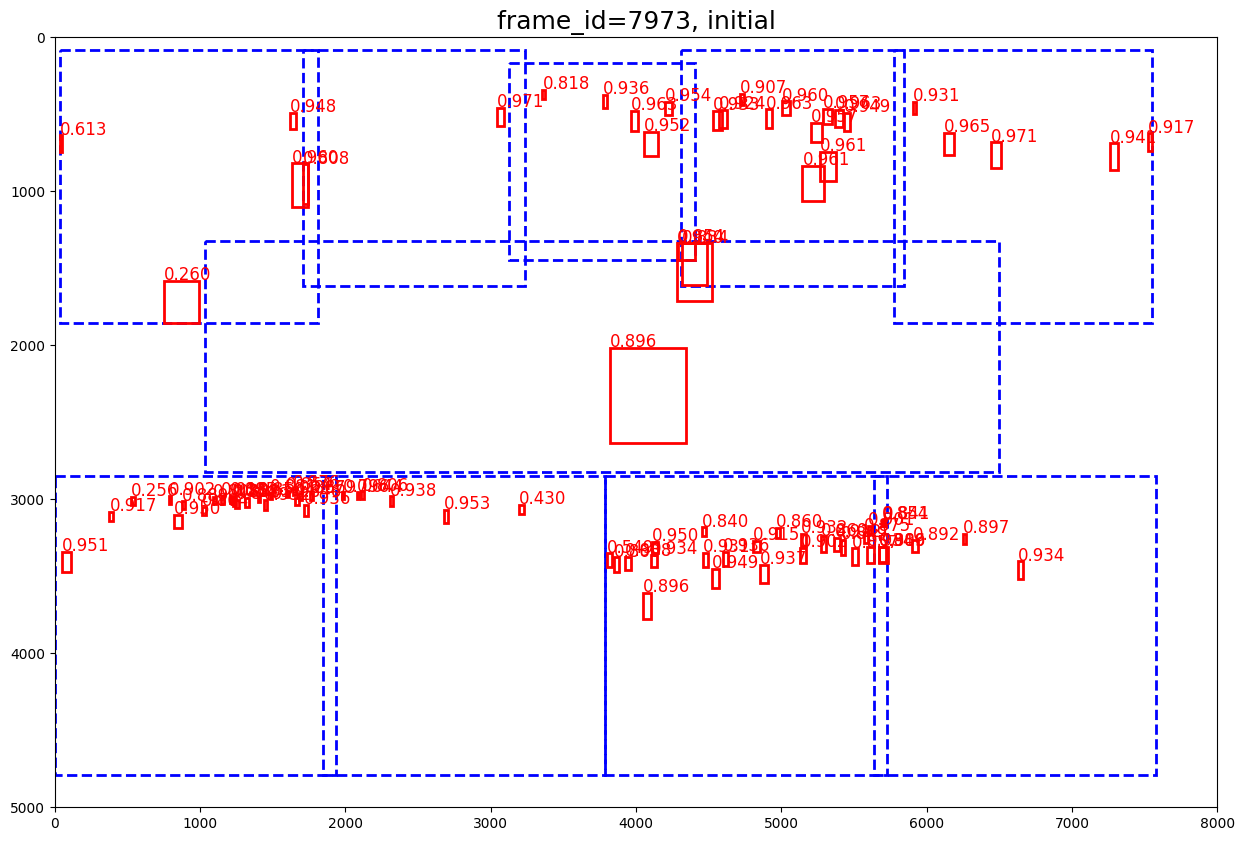

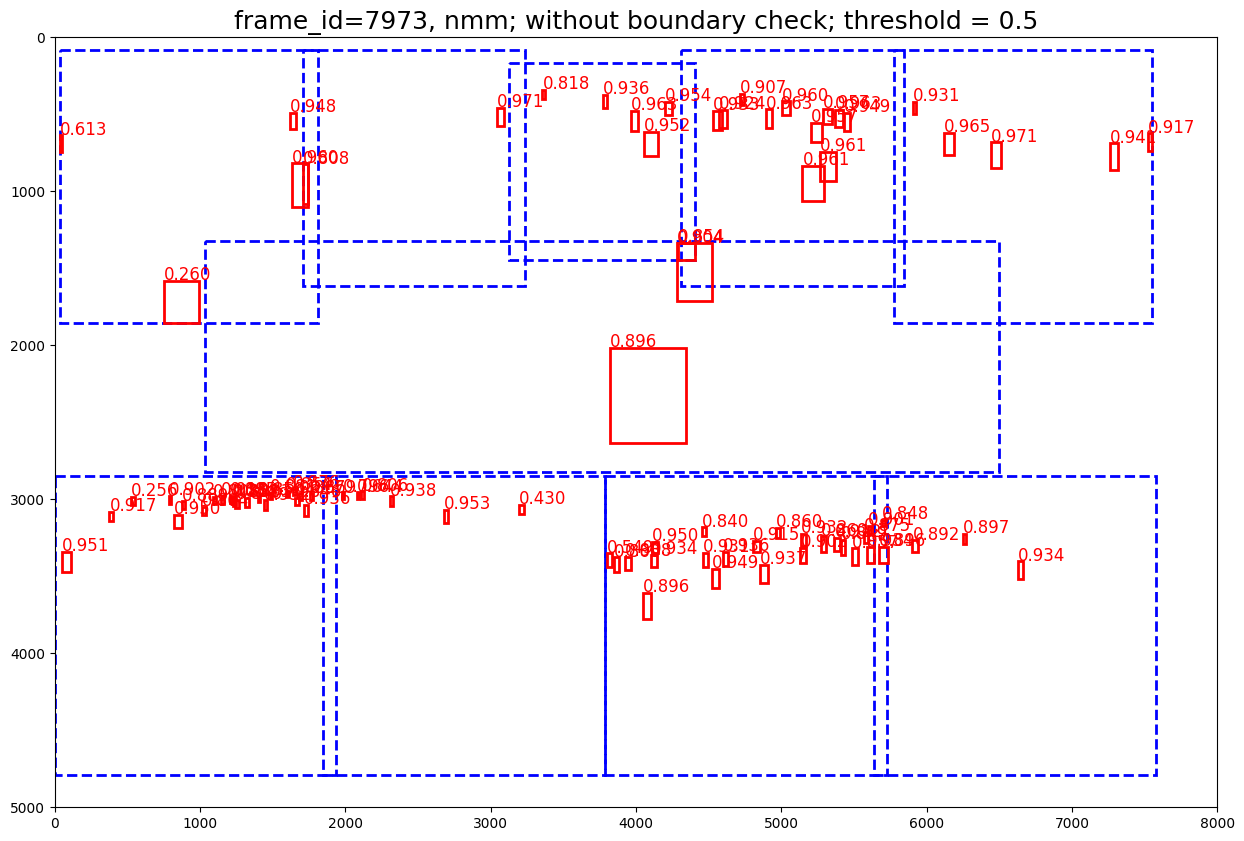

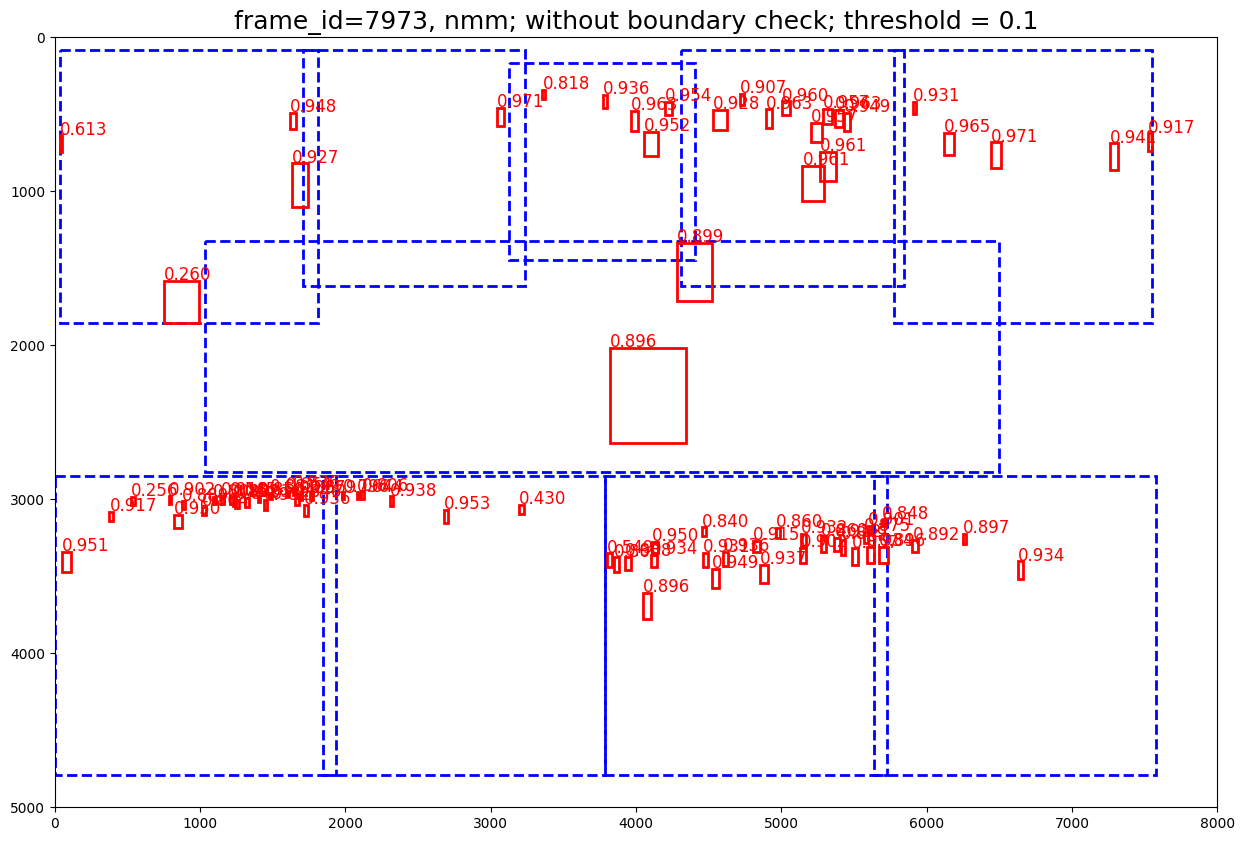

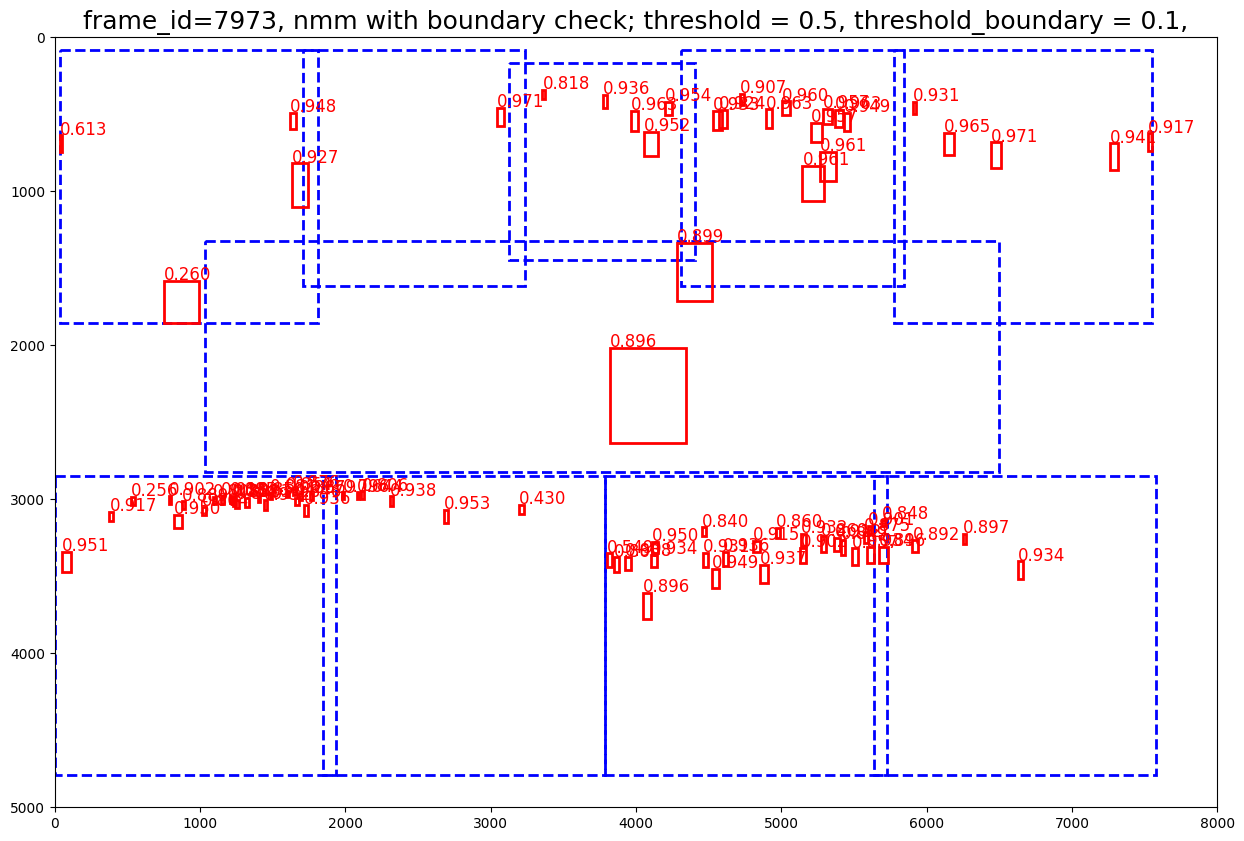

In [6]:
frame_id = 7973
draw_boxes(player_bboxes_list, frame_id, roi_tlbr = roi_tlbr_list, title = f"frame_id={frame_id}, initial")
draw_boxes(filtered_player_nmm_without_0, frame_id, roi_tlbr = roi_tlbr_list, title = f"frame_id={frame_id}, nmm; without boundary check; threshold = 0.5" )
draw_boxes(filtered_player_nmm_without_1, frame_id, roi_tlbr = roi_tlbr_list, title = f"frame_id={frame_id}, nmm; without boundary check; threshold = 0.1")
draw_boxes(filtered_player_nmm_good, frame_id, roi_tlbr = roi_tlbr_list, title = f"frame_id={frame_id}, nmm with boundary check; threshold = 0.5, threshold_boundary = 0.1,")